In [1]:
from pprint import pprint
import numpy as np
import matplotlib.pyplot as plt

# The Qiskit Cold Atom Provider

The qiskit-cold-atom module comes with a provider that manages access to cold atomic backends.

This tutorial shows the workflow of how a user interfaces with this provider.

<div class="alert alert-block alert-info">
<b>Note:</b> To run the cells in this tutorial that interface with a remote device backend, you'll need to have a registered account with a valid username and token for this backend.</div>

## Credential management

The `ColdAtomProvider` comes with an account system similar to the `IBMQ`-account, which will look familiar to many Qiskit users. This manages the access to all the backends that are available to the user.  

The necessary credentials to access remote backends can be saved to disk or used in a session and never saved. The main methods to manage credentials with the provider are the following:

- `enable_account(urls, username, token)`: Enable your account in the current session.
- `save_account(urls, username, token)`: Save your account credentials to disk for future use.
- `load_account()`: Load account using stored credentials.
- `stored_account()`: List the account credentials stored to disk.
- `active_account()`: List the account credentials currently in the session.
- `delete_account()`: Delete the saved account credentials from disk.

To access remote backends via the provider, the account credentials have to specify the third-party `url` of the desired backend and a valid `username` and `token` as a password. 

In [2]:
from qiskit_cold_atom.providers import ColdAtomProvider

# save an account to disk
# ColdAtomProvider.save_account(url = ["url_of_backend_1", "url_of_backend_2"], username="JohnDoe",token="123456") 

# load the stored account
provider = ColdAtomProvider.load_account()

## Backends

Backends of the `ColdAtomProvider` represent either simulators or a real experimental hardware based on cold atomic experiments. A user may run suitable quantum circuits on these backends and retrieve the results.

The backends of the provider can be retrieved with the following methods:

- `provider.backends()`: Returns all backend objects known to the provider.
- `provider.get_backend(NAME)`: Returns the named backend.

In [3]:
print(provider.backends())

[<FermionicTweezerSimulator('fermionic_tweezer_simulator')>, <CollectiveSpinSimulator('collective_spin_simulator')>, <SpinHardwareDevice('SYNQS_SoPa_backend')>]


The provider currently includes simulators of a fermionic tweezer hardware (introduced [here](./03_fermionic_tweezer_hardware.ipynb)) and a collective spin hardware (introduced [here](./04_collective_spin_hardware.ipynb)). 
As a first real device, an experimental system of collective spins is available, which is maintained by the Jendrzejewski group of the ["Synthetic Quantum Systems (SYNQS)"](https://www.synqs.org/) collaboration located at Heidelberg University (Germany):

In [4]:
spin_device_backend = provider.get_backend("SYNQS_SoPa_backend")

The `status` of this backend can be queried to see whether it is currently online and how many jobs are queued:

In [5]:
spin_device_backend.status().to_dict()

{'backend_name': 'SYNQS_SoPa_backend',
 'backend_version': '1',
 'operational': True,
 'pending_jobs': 0,
 'status_msg': ''}

The backend `configuration` tells the user which quantum gates the backend can implement:

In [6]:
spin_device_backend.configuration().supported_instructions

['delay', 'measure', 'barrier']

The gates and instructions made available by the backend naturally depend on the hardware developments happening on the backend. With future versions of the backend, additional gates that manipulate the collective spins in the hardware will be added. 

## Jobs:

The submission of circuits to execute on the backend is handled via `Job` instances. Circuits are submitted to the backend via the `run()` method which returns a `ColdAtomJob` object related to this submission.

The user can interact with this job to gain information about the submitted circuits with the following methods:

- `status()`: Returns the status of the job.
- `backend()`: Returns the backend the job was run on.
- `job_id()`: Gets the job_id.
- `cancel()`: Cancels the job.
- `result()`: Gets the results from the circuit run.

Let's submit some very simple example circuits on the remote backend as a toy example.
The following circuits describe the loading of atoms into a trap during the `delay` instruction. Upon measurement, the total number of atoms in the trap is measured. This should increase with increasing loading time and eventually saturate at the traps limit. 

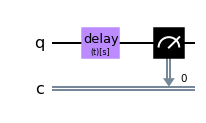

In [8]:
from qiskit.circuit import QuantumCircuit, Parameter
import numpy as np

t = Parameter("t")

circuit = QuantumCircuit(1, 1)
circuit.delay(duration = t, unit='s', qarg=0)
circuit.measure(0, 0)
circuit.draw(output='mpl')

In [9]:
# create a list of circuits with variable loading times:
load_times = np.arange(0.1, 15, 2)
circuit_list =[circuit.bind_parameters({t: load_time}) for load_time in load_times]

In [10]:
# send the list of circuits to the backend and execute with 5 shots each
# demo_job = spin_device_backend.run(circuit_list, shots = 5)

The job gets a unique `job_id` attached by the backend server which can be queried using the method `demo_job.job_id`.

### Retrieving jobs:

A job that has been run in a previous session can also be retrieved from the backend by providing the `job_id`:

In [12]:
job_retrieved = spin_device_backend.retrieve_job(job_id = "20210520_171502_89aec")

print("job status: ", job_retrieved.status())

job status:  JobStatus.DONE


The result of the job can be accessed by directly calling `job.result()` which returns a `Qiskit.Result` object:

In [13]:
result = job_retrieved.result()
print(type(result))

<class 'qiskit.result.result.Result'>


Let's look at the results of the previously submitted demo_job in detail:

In [14]:
outcomes = [result.get_memory(i) for i in range(len(circuit_list))]

atom_numbers = [np.mean(np.array(counts, dtype=float)) for counts in outcomes]
atom_stds = [np.std(np.array(counts, dtype=float)) for counts in outcomes]

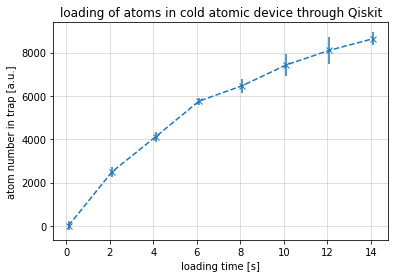

In [15]:
import matplotlib.pyplot as plt

plt.errorbar(load_times, atom_numbers, yerr=atom_stds, fmt='x--')
plt.grid(alpha=0.5)
plt.title("loading of atoms in cold atomic device through Qiskit")
plt.xlabel("loading time [s]")
plt.ylabel("atom number in trap [a.u.]")
plt.show()

The entire result object can also be viewed as a dictionary:

In [18]:
result.to_dict()

{'backend_name': 'SYNQS_SoPa_backend',
 'backend_version': '0.0.1',
 'qobj_id': None,
 'job_id': '20210520_171502_89aec',
 'success': True,
 'results': [{'shots': 5,
   'success': True,
   'data': {'memory': ['149.', '-118.', '-231.', '-68.', '317.']},
   'meas_level': <MeasLevel.CLASSIFIED: 2>,
   'header': {'name': 'experiment_0', 'extra metadata': 'text'}},
  {'shots': 5,
   'success': True,
   'data': {'memory': ['2254.', '2169.', '2635.', '2626.', '2793.']},
   'meas_level': <MeasLevel.CLASSIFIED: 2>,
   'header': {'name': 'experiment_1', 'extra metadata': 'text'}},
  {'shots': 5,
   'success': True,
   'data': {'memory': ['3688.', '4348.', '4157.', '4323.', '4023.']},
   'meas_level': <MeasLevel.CLASSIFIED: 2>,
   'header': {'name': 'experiment_2', 'extra metadata': 'text'}},
  {'shots': 5,
   'success': True,
   'data': {'memory': ['5639.', '5528.', '5765.', '5923.', '5943.']},
   'meas_level': <MeasLevel.CLASSIFIED: 2>,
   'header': {'name': 'experiment_3', 'extra metadata': 't

In [17]:
import qiskit.tools.jupyter
%qiskit_version_table
%qiskit_copyright